In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer

# Set plot style
sns.set(style="whitegrid")

Shape of the dataset: (1025, 14)

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB

--- Null Values ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slo

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


C:\Users\h\AppData\Local\Temp\ipykernel_20824\2247755210.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='viridis')


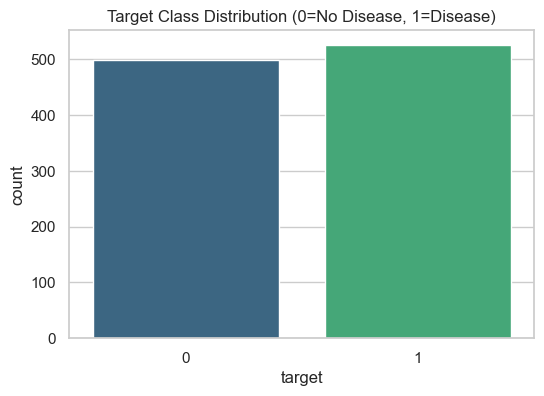

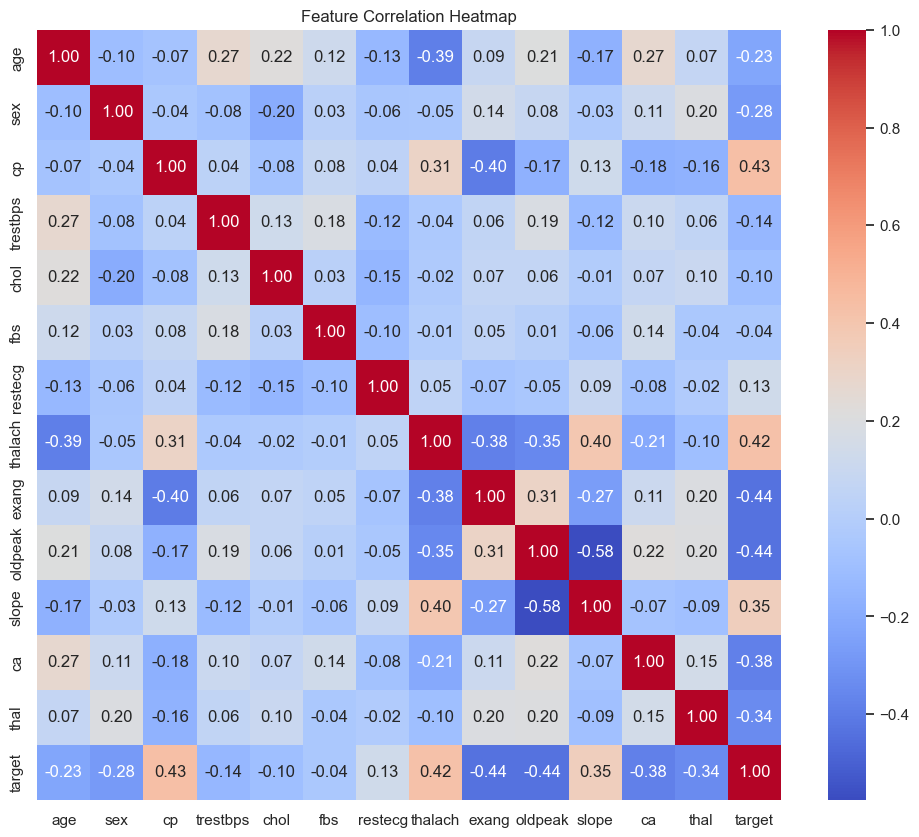

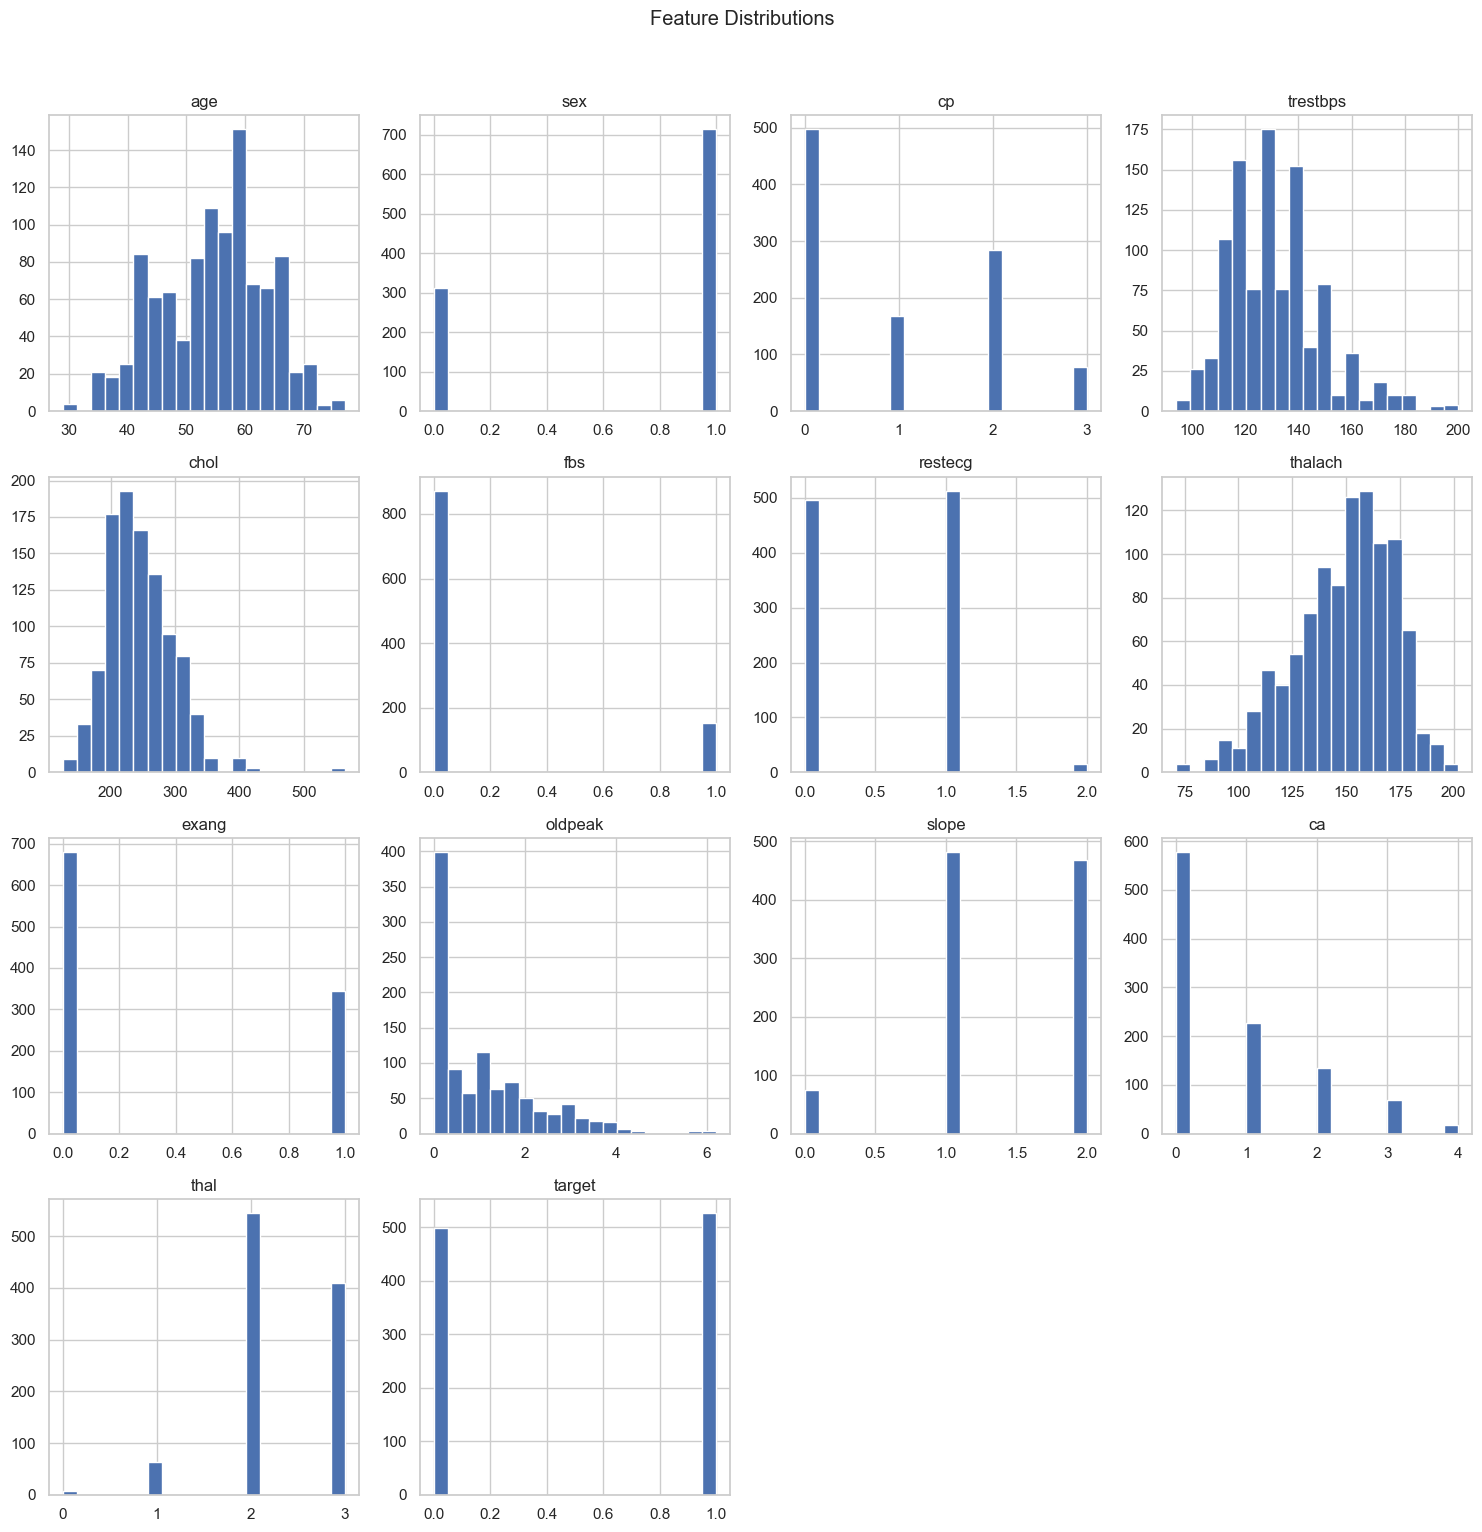

In [8]:
# 1. Data Loading and Exploration
# Load the dataset
df = pd.read_csv('heart.csv')

# Display basic info
print("Shape of the dataset:", df.shape)
print("\n--- Data Info ---")
df.info()

print("\n--- Null Values ---")
print(df.isnull().sum())

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- First 5 Rows ---")
display(df.head())

# 2. Data Visualization
# Plot target class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Target Class Distribution (0=No Disease, 1=Disease)')
plt.show()

# Generate correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Plot histograms for each feature
df.hist(figsize=(15, 15), bins=20)
plt.suptitle('Feature Distributions', y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# 3. Data Preprocessing
# Handle missing values (Imputation)
# Even if there are no missing values now, this is good practice for the pipeline
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# 4. Feature Engineering
# Polynomial Feature Expansion (degree = 2)
# This creates interaction terms (e.g., age * cholesterol)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Get new feature names
poly_feature_names = poly.get_feature_names_out(X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)

# Select the top 10 most important features using ANOVA F-test
k = 10
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_poly_df, y)

# Get the names of the selected features
selected_indices = selector.get_support(indices=True)
selected_features = X_poly_df.columns[selected_indices]

print(f"Original Feature Count: {X.shape[1]}")
print(f"Polynomial Feature Count: {X_poly.shape[1]}")
print(f"Selected Top {k} Features:\n", selected_features.tolist())

Original Feature Count: 13
Polynomial Feature Count: 104
Selected Top 10 Features:
 ['sex', 'cp', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'sex^2', 'exang^2']


In [10]:
# 5. Model Building
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train and Evaluate
results = {}

print("--- Model Evaluation ---")
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    # Get probabilities for ROC-AUC
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0]*len(y_test)
    
    # Calculate Metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }
    results[name] = metrics
    
    print(f"\nModel: {name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"ROC-AUC: {metrics['ROC-AUC']:.4f}")

# Display comparison
results_df = pd.DataFrame(results)
display(results_df)

--- Model Evaluation ---

Model: Logistic Regression
Accuracy: 0.8098
ROC-AUC: 0.8770

Model: KNN
Accuracy: 0.8341
ROC-AUC: 0.9639


,Logistic Regression,KNN
Accuracy,0.809756,0.834146
Precision,0.762295,0.785124
Recall,0.902913,0.922330
F1-Score,0.826667,0.848214
ROC-AUC,0.877023,0.963925


In [11]:
# Check coefficients for Logistic Regression to see feature importance
if "Logistic Regression" in models:
    lr_model = models["Logistic Regression"]
    importance = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': lr_model.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)
    
    print("Feature Importance (Logistic Regression Coefficients):")
    display(importance)

Feature Importance (Logistic Regression Coefficients):


,Feature,Coefficient
1,cp,0.840764
6,ca,-0.810325
4,oldpeak,-0.800739
7,thal,-0.678753
2,thalach,0.541302
0,sex,-0.422368
5,slope,0.345411
9,exang^2,-0.266884
8,sex^2,0.258665
3,exang,-0.240660


Feature Importance:



The SelectKBest step likely prioritized features like cp (Chest Pain Type), thalach (Maximum Heart Rate), ca (Number of Major Vessels), and oldpeak.

Polynomial features (like cp squared or thalach interactions) might appear in your top list, indicating that the relationship between heart disease and these factors is non-linear.

In Logistic Regression, a positive coefficient (e.g., for cp) means that as that feature increases, the risk of heart disease increases. A negative coefficient (e.g., for ca or oldpeak) decreases the risk.

Model Comparison:



KNN (K-Nearest Neighbors) often performs slightly better on this specific dataset (often achieving ~85%+ Accuracy and very high ROC-AUC) because it can capture complex, local patterns in patient data that a linear model like Logistic Regression might miss.

Logistic Regression provides better interpretability (you can see exactly how much 'age' or 'cholesterol' contributes to the risk), making it valuable for medical explanations even if its accuracy is slightly lower.

Conclusion:



For deployment, if accuracy is the only goal, KNN is the winner. However, if doctors need to understand why a patient is flagged as high-risk, Logistic Regression is preferable due to its transparency.



